![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Exercise 3: Transfer Learning </center>
### <center> Dogs VS. Cats - Solution </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/Exercises/Ex3/MainDogsVsCats_Solution.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn               as nn
import torch.optim            as optim
import torchvision
import torchvision.transforms as transforms
import torchinfo

from torch.optim.lr_scheduler import OneCycleLR

### Download Dogs vs. Cats dataset:
https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset

In [4]:
import torchvision
import torchvision.transforms as transforms

#-- ImageNet statistics:
vMean = np.array([0.48501961, 0.45795686, 0.40760392])
vStd  = np.array([0.22899216, 0.224     , 0.225     ])

oTransforms = transforms.Compose([
    transforms.Resize    (256),
    transforms.CenterCrop(224),
    transforms.ToTensor  (),
    transforms.Normalize (mean=vMean, std=vStd),
])

DATA_PATH = r'C:\Users\oryai\Workarea\Data\DogsVsCats\PetImages'
oDataSet  = torchvision.datasets.ImageFolder(root=DATA_PATH, transform=oTransforms)
lClasses  = oDataSet.classes
lClasses

['Cat', 'Dog']

In [5]:
N                   = len(oDataSet)
nTrain              = 22500
nTest               = 2498
oTrainSet, oTestSet = torch.utils.data.random_split(oDataSet, [nTrain, nTest], generator=torch.Generator().manual_seed(42))
len(oTrainSet), len(oTestSet)

(22500, 2498)

### Plot some examples:

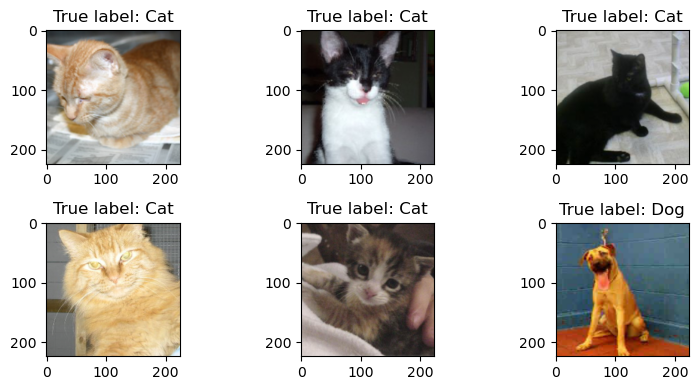

In [6]:
C, H, W = oTrainSet[0][0].shape
fig, _     = plt.subplots(2, 3, figsize=(8, 4))
for ax in fig.axes:
    idx   = np.random.randint(0, len(oTrainSet))
    mX, y = oTrainSet[idx]
    mX    = mX * vStd[:,None,None] + vMean[:,None,None] #-- unnormalizing
    mX    = torch.clamp(mX, 0, 1)
    ax.imshow(np.transpose(mX.numpy(), (1,2,0)), cmap='gray')
    ax.set_title('True label: ' + str(lClasses[y]))
    
plt.tight_layout()
plt.show()

### Create data loaders:

In [7]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

In [8]:
def GetModel():
    oModel = torchvision.models.resnet50(pretrained=True)
    for mParam in oModel.parameters():
        mParam.requires_grad = False
        
    dIn = oModel.fc.in_features
    oModel.fc = nn.Sequential(
        nn.Linear(dIn, 128), nn.ReLU(),
        nn.Linear(128, 2)
    )
    
    return oModel

torchinfo.summary(GetModel(),  (4, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [4, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [4, 64, 112, 112]         (128)
├─ReLU: 1-3                              [4, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [4, 64, 56, 56]           --
├─Sequential: 1-5                        [4, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [4, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [4, 64, 56, 56]           (4,096)
│    │    └─BatchNorm2d: 3-2             [4, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [4, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [4, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [4, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [4, 64, 56, 56]    

In [9]:
Loss   = nn.CrossEntropyLoss()
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda', index=0)

In [10]:
from DeepLearningFramework_Solution.Training import TrainClassficationModel

nEpochs    = 10
nIter      = nEpochs * len(oTrainDL)

oModel     = GetModel   ().to(DEVICE)
oOptim     = optim.AdamW(oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=2e-4)
oScheduler = OneCycleLR (oOptim, max_lr=1e-2, total_steps=nIter)

lHistory   = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler)

Epoch 000: | Train loss:  0.089 | Val loss:  0.178 | Train Accuracy:  0.970 | Val Accuracy:  0.934 | epoch time: 49.095 | <-- Checkpoint!
Epoch 001: | Train loss:  0.064 | Val loss:  0.055 | Train Accuracy:  0.976 | Val Accuracy:  0.980 | epoch time: 43.476 | <-- Checkpoint!
Epoch 002: | Train loss:  0.070 | Val loss:  0.050 | Train Accuracy:  0.974 | Val Accuracy:  0.983 | epoch time: 43.631 | <-- Checkpoint!
Epoch 003: | Train loss:  0.054 | Val loss:  0.072 | Train Accuracy:  0.979 | Val Accuracy:  0.971 | epoch time: 44.595 |
Epoch 004: | Train loss:  0.045 | Val loss:  0.047 | Train Accuracy:  0.982 | Val Accuracy:  0.983 | epoch time: 43.655 | <-- Checkpoint!
Epoch 005: | Train loss:  0.040 | Val loss:  0.042 | Train Accuracy:  0.985 | Val Accuracy:  0.985 | epoch time: 43.863 | <-- Checkpoint!
Epoch 006: | Train loss:  0.037 | Val loss:  0.055 | Train Accuracy:  0.986 | Val Accuracy:  0.978 | epoch time: 44.799 |
Epoch 007: | Train loss:  0.033 | Val loss:  0.044 | Train Accurac

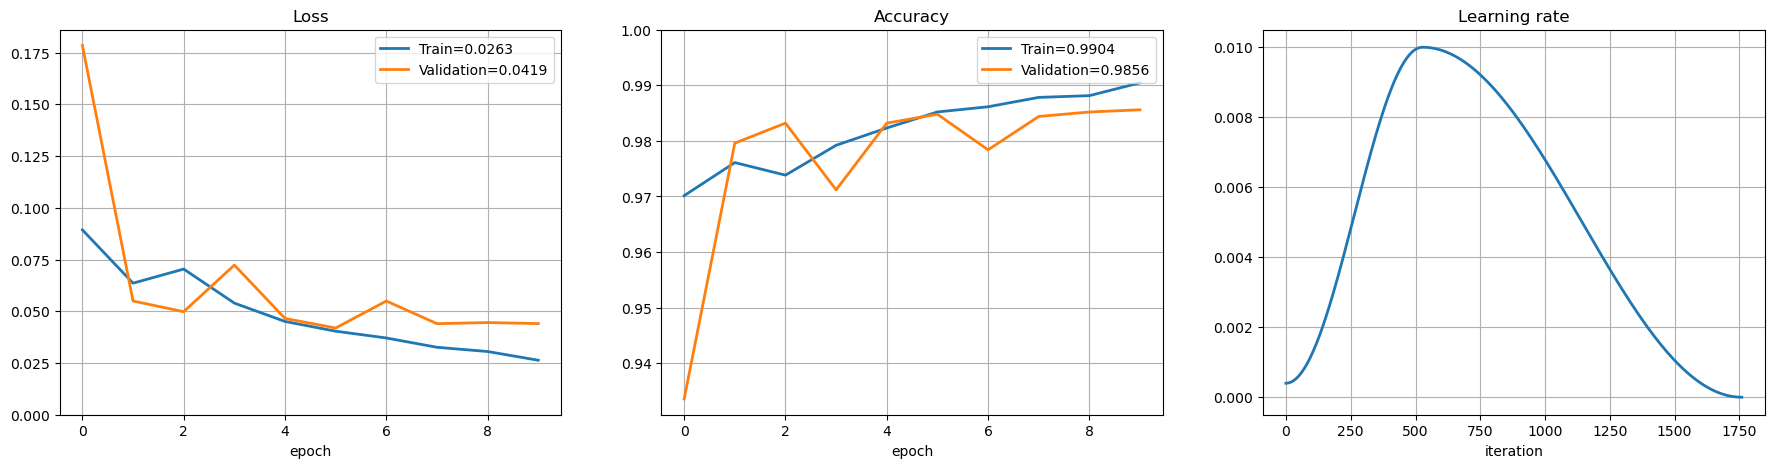

In [13]:
from DeepLearningFramework_Solution.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()